In [1]:
##### Copyright 2018 The TensorFlow Authors.

# Licensed under the Apache License, Version 2.0 (the "License");

#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
%cd ..
from set_env import temp_dir

# tf.data：构建 TensorFlow 输入流水线

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://tensorflow.google.cn/guide/data"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">View 在 TensorFlow.org 上查看</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/guide/data.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行 </a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/guide/data.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 GitHub 中查看源代码</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/guide/data.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a></td>
</table>

借助 `tf.data` API，您可以根据简单的可重用片段构建复杂的输入流水线。例如，图像模型的流水线可以聚合来自分布式文件系统中文件的数据，对每个图像应用随机扰动，并将随机选中的图像合并成一个批次进行训练。文本模型的流水线可能涉及从原始文本数据中提取符号，将提取的符号转换为带有查找表的嵌入向量标识符，并将不同长度的序列组合成一个批次。`tf.data` API 可以处理大量数据、从不同的数据格式读取数据和执行复杂的转换。

`tf.data` API 引入了一个 `tf.data.Dataset` 抽象，它表示一个元素序列，其中每个元素都由一个或多个组件组成。例如，在一个图像流水线中，一个元素可能是一个训练样本，有一对表示图像及其标签的张量组件。

您可以通过两种不同的方式创建数据集：

- 数据**源**从存储在内存中或存储在一个或多个文件中的数据构造 `Dataset`。

- 数据**转换**从一个或多个 `tf.data.Dataset` 对象构造数据集。


In [2]:
import tensorflow as tf

2024-10-25 20:20:27.526062: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-25 20:20:27.549946: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-25 20:20:27.556126: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-25 20:20:27.571284: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-25 20:20:28.811678: W tensorflow/compiler/tf2

In [3]:
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

np.set_printoptions(precision=4)

## 基本机制

<a id="basic-mechanics"></a>

要创建输入流水线，您必须从数据*源*开始。例如，要从内存中的数据构造一个 `Dataset`，您可以使用 `tf.data.Dataset.from_tensors()` 或 `tf.data.Dataset.from_tensor_slices()`。或者，如果您的输入数据以推荐的 TFRecord 格式存储在文件中，则您可以使用 `tf.data.TFRecordDataset()`。

有了一个 `Dataset` 对象之后，您可以通过链接 <code>tf.data.Dataset</code> 对象上的方法调用将其<em>转换</em>成一个新的 `Dataset`。例如，您可以应用逐元素转换（例如 `Dataset.map`）和多元素转换（例如 `Dataset.batch`）。有关完整的转换列表，请参阅 `tf.data.Dataset` 文档。

`Dataset` 对象是一个 Python 可迭代对象。这使得利用 for 循环使用它的元素成为可能：

In [4]:
dataset = tf.data.Dataset.from_tensor_slices([8, 3, 0, 8, 2, 1])
dataset

2024-10-25 20:20:31.087240: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1040 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:03:00.0, compute capability: 8.6
2024-10-25 20:20:31.087848: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9488 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:81:00.0, compute capability: 7.5


<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int32, name=None)>

In [5]:
for elem in dataset:
  print(elem.numpy())

8
3
0
8
2
1


2024-10-25 20:20:31.152028: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


或者使用 `iter` 显式创建一个 Python 迭代器，并利用 `next` 来使用它的元素：

In [6]:
it = iter(dataset)

print(next(it).numpy())

8


或者，还可以利用 `reduce` 转换来使用数据集元素，从而减少所有元素以生成单个结果。以下示例演示了如何使用 `reduce` 转换来计算整数数据集的和。

In [7]:
print(dataset.reduce(0, lambda state, value: state + value).numpy())

22


<!-- TODO(jsimsa): Talk about `tf.function` support. -->

<a id="dataset_structure"></a>

### 数据集结构

数据集会生成一系列*元素*，其中每个元素都是*组件*的相同（嵌套）结构。结构的各个组件可以是可由 `tf.TypeSpec` 表示的任何类型，包括 `tf.Tensor`、`tf.sparse.SparseTensor`、`tf.RaggedTensor`、`tf.TensorArray` 或 `tf.data.Dataset`。

可用于表达元素的（嵌套）结构的 Python 构造包括 `tuple`、`dict`、`NamedTuple` 和 `OrderedDict`。特别要指出的是，`list` 不是用于表达数据集元素结构的有效构造。这是因为早期的 `tf.data` 用户坚决要求将 `list` 输入（例如，传递到 `tf.data.Dataset.from_tensors` 时）自动打包为张量，并将 `list` 输出（例如，用户定义函数的返回值）强制转换为 `tuple`。因此，如果您希望将 `list` 输入视为结构，则需要将其转换为 `tuple`，而如果要将 `list` 输出作为单个组件，则需要使用 `tf.stack` 将其显式打包。

`Dataset.element_spec` 属性允许您检查每个元素组件的类型。该属性会返回 <code>tf.TypeSpec</code> 对象与元素结构相匹配的<em>嵌套结构</em>，可以是单个组件、组件元组，或者组件的嵌套元组。例如：

In [8]:
dataset1 = tf.data.Dataset.from_tensor_slices(tf.random.uniform([4, 10]))

dataset1.element_spec

TensorSpec(shape=(10,), dtype=tf.float32, name=None)

In [9]:
dataset2 = tf.data.Dataset.from_tensor_slices(
   (tf.random.uniform([4]),
    tf.random.uniform([4, 100], maxval=100, dtype=tf.int32)))

dataset2.element_spec

(TensorSpec(shape=(), dtype=tf.float32, name=None),
 TensorSpec(shape=(100,), dtype=tf.int32, name=None))

In [10]:
dataset3 = tf.data.Dataset.zip((dataset1, dataset2))

dataset3.element_spec

(TensorSpec(shape=(10,), dtype=tf.float32, name=None),
 (TensorSpec(shape=(), dtype=tf.float32, name=None),
  TensorSpec(shape=(100,), dtype=tf.int32, name=None)))

In [11]:
# Dataset containing a sparse tensor.
dataset4 = tf.data.Dataset.from_tensors(tf.SparseTensor(indices=[[0, 0], [1, 2]], values=[1, 2], dense_shape=[3, 4]))

dataset4.element_spec

SparseTensorSpec(TensorShape([3, 4]), tf.int32)

In [12]:
# Use value_type to see the type of value represented by the element spec
dataset4.element_spec.value_type

tensorflow.python.framework.sparse_tensor.SparseTensor

`Dataset` 转换支持任何结构的数据集。使用 `Dataset.map` 和 `Dataset.filter` 转换时会将函数应用于每个元素，而元素结构会决定函数的参数：

In [13]:
dataset1 = tf.data.Dataset.from_tensor_slices(
    tf.random.uniform([4, 10], minval=1, maxval=10, dtype=tf.int32))

dataset1

<_TensorSliceDataset element_spec=TensorSpec(shape=(10,), dtype=tf.int32, name=None)>

In [14]:
for z in dataset1:
  print(z.numpy())

[8 7 6 4 5 8 8 7 4 7]
[1 3 3 4 3 6 4 8 5 2]
[1 9 7 6 5 5 5 1 1 5]
[6 5 3 8 7 5 8 7 8 6]


2024-10-25 20:20:31.311675: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [15]:
dataset2 = tf.data.Dataset.from_tensor_slices(
   (tf.random.uniform([4]),
    tf.random.uniform([4, 100], maxval=100, dtype=tf.int32)))

dataset2

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.float32, name=None), TensorSpec(shape=(100,), dtype=tf.int32, name=None))>

In [16]:
dataset3 = tf.data.Dataset.zip((dataset1, dataset2))

dataset3

<_ZipDataset element_spec=(TensorSpec(shape=(10,), dtype=tf.int32, name=None), (TensorSpec(shape=(), dtype=tf.float32, name=None), TensorSpec(shape=(100,), dtype=tf.int32, name=None)))>

In [17]:
for a, (b,c) in dataset3:
  print('shapes: {a.shape}, {b.shape}, {c.shape}'.format(a=a, b=b, c=c))

shapes: (10,), (), (100,)
shapes: (10,), (), (100,)
shapes: (10,), (), (100,)
shapes: (10,), (), (100,)


## 读取输入数据


### 使用 NumPy 数组

请参阅[加载 NumPy 数组](../tutorials/load_data/numpy.ipynb)教程了解更多示例。

如果您所有的输入数据都适合装入内存，那么从这些数据创建 `Dataset` 的最简单方式是将它们转换为 `tf.Tensor` 对象并使用 `Dataset.from_tensor_slices`。

In [18]:
train, test = tf.keras.datasets.fashion_mnist.load_data()

In [19]:
images, labels = train
images = images/255

dataset = tf.data.Dataset.from_tensor_slices((images, labels))
dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(28, 28), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.uint8, name=None))>

注：上面的代码段会将 `features` 和 `labels` 数组作为 `tf.constant()` 运算嵌入到 TensorFlow 计算图中。这对于小数据集来说效果很好，但是会浪费内存（因为数组的内容会被多次复制），并且可能会达到 `tf.GraphDef` 协议缓冲区的 2GB 上限。

### 使用 Python 生成器

另一个可被轻松整合为 `tf.data.Dataset` 的常用数据源是 Python 生成器。

小心：虽然这种方式比较简便，但它的可移植性和可扩缩性有限。它必须在创建生成器的同一 Python 进程中运行，且仍受 Python [GIL](https://en.wikipedia.org/wiki/Global_interpreter_lock) 约束。

In [20]:
def count(stop):
  i = 0
  while i<stop:
    yield i
    i += 1

In [21]:
for n in count(5):
  print(n)

0
1
2
3
4


`Dataset.from_generator` 构造函数会将 Python 生成器转换为具有完整功能的 `tf.data.Dataset`。

构造函数会获取可调用对象作为输入，而非迭代器。这样，构造函数结束后便可重启生成器。构造函数会获取一个可选的 `args` 参数，作为可调用对象的参数。

`output_types` 参数是必需的，因为 `tf.data` 会在内部构建 `tf.Graph`，而计算图边缘需要 `tf.dtype`。

In [22]:
ds_counter = tf.data.Dataset.from_generator(count, args=[25], output_types=tf.int32, output_shapes = (), )

In [23]:
for count_batch in ds_counter.repeat().batch(10).take(10):
  print(count_batch.numpy())

[0 1 2 3 4 5 6 7 8 9]
[10 11 12 13 14 15 16 17 18 19]
[20 21 22 23 24  0  1  2  3  4]
[ 5  6  7  8  9 10 11 12 13 14]
[15 16 17 18 19 20 21 22 23 24]
[0 1 2 3 4 5 6 7 8 9]
[10 11 12 13 14 15 16 17 18 19]
[20 21 22 23 24  0  1  2  3  4]
[ 5  6  7  8  9 10 11 12 13 14]
[15 16 17 18 19 20 21 22 23 24]


2024-10-25 20:20:32.758308: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


`output_shapes` 参数虽然不是*必需的*，但强烈建议添加，因为许多 TensorFlow 运算不支持秩未知的张量。如果特定轴的长度未知或可变，请在 `output_shapes` 中将其设置为 `None`。

还需要注意的是，`output_shapes` 和 `output_types` 与其他数据集方法遵循相同的嵌套规则。

下面的示例生成器对两方面进行了演示，它会返回由数组组成的元组，其中第二个数组是长度未知的向量。

In [24]:
def gen_series():
  i = 0
  while True:
    size = np.random.randint(0, 10)
    yield i, np.random.normal(size=(size,))
    i += 1

In [25]:
for i, series in gen_series():
  print(i, ":", str(series))
  if i > 5:
    break

0 : [ 0.1569  0.6271 -1.1095  0.6218  0.4292]
1 : [-0.5631 -0.0666]
2 : []
3 : [ 0.4259 -0.3203 -0.4641 -1.3816]
4 : [ 0.4377 -1.1177  0.1664 -1.3378  1.6449 -0.0335  1.4832 -0.6187]
5 : [-0.461  -0.4841 -0.4866  0.2065  0.386 ]
6 : [-0.439   1.326  -0.8287 -1.6944  0.1419  0.1459 -1.5565 -0.5061]


第一个输出是 `int32`，第二个输出是 `float32`。

第一个条目是标量，形状为 `()`，第二个条目是长度未知的向量，形状为 `(None,)` 

In [26]:
ds_series = tf.data.Dataset.from_generator(
    gen_series, 
    output_types=(tf.int32, tf.float32), 
    output_shapes=((), (None,)))

ds_series

<_FlatMapDataset element_spec=(TensorSpec(shape=(), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

现在，可以将它当作常规 `tf.data.Dataset` 使用。请注意，在批处理形状可变的数据集时，需要使用 `Dataset.padded_batch`。

In [27]:
ds_series_batch = ds_series.shuffle(20).padded_batch(10)

ids, sequence_batch = next(iter(ds_series_batch))
print(ids.numpy())
print()
print(sequence_batch.numpy())

[ 7  8 14 13 10 18  3  5 16 19]

[[-0.3513  0.      0.      0.      0.      0.      0.      0.      0.    ]
 [-1.0424 -0.4761 -0.3326  0.5606 -0.2229  1.0434 -0.5752 -0.8058  0.1835]
 [-0.5073  1.0952 -1.0249 -0.4266  0.3491 -0.3648  1.1227  3.0017 -0.9546]
 [ 0.4433  0.      0.      0.      0.      0.      0.      0.      0.    ]
 [-1.4428 -0.0814  0.      0.      0.      0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.      0.      0.      0.      0.      0.    ]
 [ 0.5574 -0.296  -0.2654 -0.9671 -1.2644  0.      0.      0.      0.    ]
 [ 0.1701 -0.6157  0.5734 -0.598  -1.634  -1.2099  0.      0.      0.    ]
 [-1.7023  0.      0.      0.      0.      0.      0.      0.      0.    ]
 [ 1.5982  0.6375 -0.9791  2.5224 -0.14    1.3503  0.      0.      0.    ]]


举个更加实际的例子，请尝试将 `preprocessing.image.ImageDataGenerator` 封装为 `tf.data.Dataset`。

先下载数据：

In [28]:
flowers = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 45s 0us/step


创建 `image.ImageDataGenerator`

In [29]:
img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, rotation_range=20)

In [30]:
images, labels = next(img_gen.flow_from_directory(flowers))

Found 3670 images belonging to 5 classes.


In [31]:
print(images.dtype, images.shape)
print(labels.dtype, labels.shape)

float32 (32, 256, 256, 3)
float32 (32, 5)


In [32]:
ds = tf.data.Dataset.from_generator(
    lambda: img_gen.flow_from_directory(flowers), 
    output_types=(tf.float32, tf.float32), 
    output_shapes=([32,256,256,3], [32,5])
)

ds.element_spec

(TensorSpec(shape=(32, 256, 256, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(32, 5), dtype=tf.float32, name=None))

In [33]:
for images, labels in ds.take(1):
  print('images.shape: ', images.shape)
  print('labels.shape: ', labels.shape)


Found 3670 images belonging to 5 classes.
images.shape:  (32, 256, 256, 3)
labels.shape:  (32, 5)


### 处理 TFRecord 数据

请参阅[加载 TFRecord](../tutorials/load_data/tfrecord.ipynb) 教程了解端到端示例。

`tf.data` API 支持多种文件格式，因此可以处理不适合存储在内存中的大型数据集。例如，TFRecord 文件格式是一种简单的、面向记录的二进制格式，许多 TensorFlow 应用都将其用于训练数据。您可以利用 `tf.data.TFRecordDataset` 类将一个或多个 TFRecord 文件的内容作为输入流水线的一部分进行流式传输。

下面的示例使用了来自 French Street Name Signs (FSNS) 的测试文件。

In [34]:
# Creates a dataset that reads all of the examples from two files.
fsns_test_file = tf.keras.utils.get_file("fsns.tfrec", "https://storage.googleapis.com/download.tensorflow.org/data/fsns-20160927/testdata/fsns-00000-of-00001")

7904079/7904079 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


`TFRecordDataset` 初始值设定项的 `filenames` 参数可以是字符串、字符串列表，或由字符串组成的 `tf.Tensor`。因此，如果您有两组分别用于训练和验证的文件，则可以创建一个工厂方法来生成数据集，并将文件名作为输入参数：


In [35]:
dataset = tf.data.TFRecordDataset(filenames = [fsns_test_file])
dataset

<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

许多 TensorFlow 项目在其 TFRecord 文件中使用序列化的 `tf.train.Example` 记录。这些记录需要在检查前进行解码：

In [36]:
raw_example = next(iter(dataset))
parsed = tf.train.Example.FromString(raw_example.numpy())

parsed.features.feature['image/text']

bytes_list {
  value: "Rue Perreyon"
}

### 使用文本数据

请参阅[加载文本](../tutorials/load_data/text.ipynb)教程了解端到端示例。

许多数据集会作为一个或多个文本文件进行分发。`tf.data.TextLineDataset` 提供了一种从一个或多个文本文件中提取行的简便方式。如果给定一个或多个文件名，`TextLineDataset` 会为这些文件的每一行生成一个字符串元素。

In [37]:
directory_url = 'https://storage.googleapis.com/download.tensorflow.org/data/illiad/'
file_names = ['cowper.txt', 'derby.txt', 'butler.txt']

file_paths = [
    tf.keras.utils.get_file(file_name, directory_url + file_name)
    for file_name in file_names
]

815980/815980 ━━━━━━━━━━━━━━━━━━━━ 2s 2us/step
809730/809730 ━━━━━━━━━━━━━━━━━━━━ 2s 2us/step
807992/807992 ━━━━━━━━━━━━━━━━━━━━ 2s 2us/step


In [38]:
dataset = tf.data.TextLineDataset(file_paths)

这是第一个文件的前几行：

In [39]:
for line in dataset.take(5):
  print(line.numpy())

b"\xef\xbb\xbfAchilles sing, O Goddess! Peleus' son;"
b'His wrath pernicious, who ten thousand woes'
b"Caused to Achaia's host, sent many a soul"
b'Illustrious into Ades premature,'
b'And Heroes gave (so stood the will of Jove)'


要交错不同文件中的行，请使用 `Dataset.interleave`。这样可以更轻松地重排文件。以下是来自每个转换的第一、第二和第三行：

In [40]:
files_ds = tf.data.Dataset.from_tensor_slices(file_paths)
lines_ds = files_ds.interleave(tf.data.TextLineDataset, cycle_length=3)

for i, line in enumerate(lines_ds.take(9)):
  if i % 3 == 0:
    print()
  print(line.numpy())


b"\xef\xbb\xbfAchilles sing, O Goddess! Peleus' son;"
b"\xef\xbb\xbfOf Peleus' son, Achilles, sing, O Muse,"
b'\xef\xbb\xbfSing, O goddess, the anger of Achilles son of Peleus, that brought'

b'His wrath pernicious, who ten thousand woes'
b'The vengeance, deep and deadly; whence to Greece'
b'countless ills upon the Achaeans. Many a brave soul did it send'

b"Caused to Achaia's host, sent many a soul"
b'Unnumbered ills arose; which many a soul'
b'hurrying down to Hades, and many a hero did it yield a prey to dogs and'


默认情况下，`TextLineDataset` 会生成每个文件的*每一*行，但这可能并不理想（例如，有时文件会以标题行开始，或者包含注释）。可以使用 `Dataset.skip()` 或 `Dataset.filter` 转换移除这些行。如下所示，跳过第一行，然后过滤出剩余内容。

In [41]:
titanic_file = tf.keras.utils.get_file("train.csv", "https://storage.googleapis.com/tf-datasets/titanic/train.csv")
titanic_lines = tf.data.TextLineDataset(titanic_file)

30874/30874 ━━━━━━━━━━━━━━━━━━━━ 0s 11us/step


In [42]:
for line in titanic_lines.take(10):
  print(line.numpy())

b'survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone'
b'0,male,22.0,1,0,7.25,Third,unknown,Southampton,n'
b'1,female,38.0,1,0,71.2833,First,C,Cherbourg,n'
b'1,female,26.0,0,0,7.925,Third,unknown,Southampton,y'
b'1,female,35.0,1,0,53.1,First,C,Southampton,n'
b'0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y'
b'0,male,2.0,3,1,21.075,Third,unknown,Southampton,n'
b'1,female,27.0,0,2,11.1333,Third,unknown,Southampton,n'
b'1,female,14.0,1,0,30.0708,Second,unknown,Cherbourg,n'
b'1,female,4.0,1,1,16.7,Third,G,Southampton,n'


2024-10-25 20:21:35.858507: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [43]:
def survived(line):
  return tf.not_equal(tf.strings.substr(line, 0, 1), "0")

survivors = titanic_lines.skip(1).filter(survived)

In [44]:
for line in survivors.take(10):
  print(line.numpy())

b'1,female,38.0,1,0,71.2833,First,C,Cherbourg,n'
b'1,female,26.0,0,0,7.925,Third,unknown,Southampton,y'
b'1,female,35.0,1,0,53.1,First,C,Southampton,n'
b'1,female,27.0,0,2,11.1333,Third,unknown,Southampton,n'
b'1,female,14.0,1,0,30.0708,Second,unknown,Cherbourg,n'
b'1,female,4.0,1,1,16.7,Third,G,Southampton,n'
b'1,male,28.0,0,0,13.0,Second,unknown,Southampton,y'
b'1,female,28.0,0,0,7.225,Third,unknown,Cherbourg,y'
b'1,male,28.0,0,0,35.5,First,A,Southampton,y'
b'1,female,38.0,1,5,31.3875,Third,unknown,Southampton,n'


### 使用 CSV 数据

请参阅[加载 CSV 文件](../tutorials/load_data/csv.ipynb)和[加载 Pandas DataFrame](../tutorials/load_data/pandas_dataframe.ipynb) 教程了解更多示例。

CSV 文件格式是一种以纯文本形式存储表格数据的流行格式。

例如：

In [45]:
titanic_file = tf.keras.utils.get_file("train.csv", "https://storage.googleapis.com/tf-datasets/titanic/train.csv")

In [46]:
df = pd.read_csv(titanic_file)
df.head()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,1,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,1,female,35.0,1,0,53.1000,First,C,Southampton,n
4,0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


如果您的数据适合存储在内存中，那么 `Dataset.from_tensor_slices` 方法对字典同样有效，使这些数据可以被轻松导入：

In [47]:
titanic_slices = tf.data.Dataset.from_tensor_slices(dict(df))

for feature_batch in titanic_slices.take(1):
  for key, value in feature_batch.items():
    print("  {!r:20s}: {}".format(key, value))

  'survived'          : 0
  'sex'               : b'male'
  'age'               : 22.0
  'n_siblings_spouses': 1
  'parch'             : 0
  'fare'              : 7.25
  'class'             : b'Third'
  'deck'              : b'unknown'
  'embark_town'       : b'Southampton'
  'alone'             : b'n'


更具可扩展性的方式是根据需要从磁盘加载。

`tf.data` 模块提供了从一个或多个符合 [RFC 4180](https://tools.ietf.org/html/rfc4180) 的 CSV 文件提取记录的方法。

`experimental.make_csv_dataset` 函数是用来读取 CSV 文件集的高级接口。它支持列类型推断和许多其他功能，如批处理和重排，以简化使用。

In [48]:
titanic_batches = tf.data.experimental.make_csv_dataset(
    titanic_file, batch_size=4,
    label_name="survived")

In [49]:
for feature_batch, label_batch in titanic_batches.take(1):
  print("'survived': {}".format(label_batch))
  print("features:")
  for key, value in feature_batch.items():
    print("  {!r:20s}: {}".format(key, value))

'survived': [0 0 1 1]
features:
  'sex'               : [b'male' b'male' b'male' b'female']
  'age'               : [19. 40.  1. 23.]
  'n_siblings_spouses': [0 1 1 1]
  'parch'             : [0 4 2 0]
  'fare'              : [  8.05   27.9    20.575 113.275]
  'class'             : [b'Third' b'Third' b'Third' b'First']
  'deck'              : [b'unknown' b'unknown' b'unknown' b'D']
  'embark_town'       : [b'Southampton' b'Southampton' b'Southampton' b'Cherbourg']
  'alone'             : [b'y' b'n' b'n' b'n']


如果只需要列的一个子集，您可以使用 `select_columns` 参数。

In [50]:
titanic_batches = tf.data.experimental.make_csv_dataset(
    titanic_file, batch_size=4,
    label_name="survived", select_columns=['class', 'fare', 'survived'])

In [51]:
for feature_batch, label_batch in titanic_batches.take(1):
  print("'survived': {}".format(label_batch))
  for key, value in feature_batch.items():
    print("  {!r:20s}: {}".format(key, value))

'survived': [0 0 0 1]
  'fare'              : [ 7.925 13.    31.275 26.   ]
  'class'             : [b'Third' b'Second' b'Third' b'Second']


还有一个级别更低的 `experimental.CsvDataset` 类，该类可以提供粒度更细的控制，但它不支持列类型推断，您必须指定每个列的类型。

In [52]:
titanic_types  = [tf.int32, tf.string, tf.float32, tf.int32, tf.int32, tf.float32, tf.string, tf.string, tf.string, tf.string]
dataset = tf.data.experimental.CsvDataset(titanic_file, titanic_types , header=True)

for line in dataset.take(10):
  print([item.numpy() for item in line])

[0, b'male', 22.0, 1, 0, 7.25, b'Third', b'unknown', b'Southampton', b'n']
[1, b'female', 38.0, 1, 0, 71.2833, b'First', b'C', b'Cherbourg', b'n']
[1, b'female', 26.0, 0, 0, 7.925, b'Third', b'unknown', b'Southampton', b'y']
[1, b'female', 35.0, 1, 0, 53.1, b'First', b'C', b'Southampton', b'n']
[0, b'male', 28.0, 0, 0, 8.4583, b'Third', b'unknown', b'Queenstown', b'y']
[0, b'male', 2.0, 3, 1, 21.075, b'Third', b'unknown', b'Southampton', b'n']
[1, b'female', 27.0, 0, 2, 11.1333, b'Third', b'unknown', b'Southampton', b'n']
[1, b'female', 14.0, 1, 0, 30.0708, b'Second', b'unknown', b'Cherbourg', b'n']
[1, b'female', 4.0, 1, 1, 16.7, b'Third', b'G', b'Southampton', b'n']
[0, b'male', 20.0, 0, 0, 8.05, b'Third', b'unknown', b'Southampton', b'y']


如果某些列为空，则此低级接口允许您提供默认值，而非列类型。

In [53]:
%%writefile missing.csv
1,2,3,4
,2,3,4
1,,3,4
1,2,,4
1,2,3,
,,,

Writing missing.csv


In [54]:
# Creates a dataset that reads all of the records from two CSV files, each with
# four float columns which may have missing values.

record_defaults = [999,999,999,999]
dataset = tf.data.experimental.CsvDataset(temp_dir/"missing.csv", record_defaults)
dataset = dataset.map(lambda *items: tf.stack(items))
dataset

<_MapDataset element_spec=TensorSpec(shape=(4,), dtype=tf.int32, name=None)>

In [55]:
for line in dataset:
  print(line.numpy())

[1 2 3 4]
[999   2   3   4]
[  1 999   3   4]
[  1   2 999   4]
[  1   2   3 999]
[999 999 999 999]


默认情况下，`CsvDataset` 会生成文件*每一*行的*每一*列，但这可能并不理想（例如，有时文件会以一个应该忽略的标题行开始，或者输入中不需要某些列）。可以分别使用 `header` 和 `select_cols` 参数移除这些行和字段。

In [56]:
# Creates a dataset that reads all of the records from two CSV files with
# headers, extracting float data from columns 2 and 4.
record_defaults = [999, 999] # Only provide defaults for the selected columns
dataset = tf.data.experimental.CsvDataset("missing.csv", record_defaults, select_cols=[1, 3])
dataset = dataset.map(lambda *items: tf.stack(items))
dataset

<_MapDataset element_spec=TensorSpec(shape=(2,), dtype=tf.int32, name=None)>

In [57]:
for line in dataset:
  print(line.numpy())

[2 4]
[2 4]
[999   4]
[2 4]
[  2 999]
[999 999]


### 使用文件集

许多数据集会作为文件集进行分发，其中，每个文件都是一个样本。

In [58]:
flowers_root = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)
flowers_root = pathlib.Path(flowers_root)


注：这些图像已获得 CC-BY 许可，请参阅 LICENSE.txt 以了解详情。

根目录包含每个类的路径：

In [59]:
for item in flowers_root.glob("*"):
  print(item.name)

daisy
tulips
dandelion
LICENSE.txt
sunflowers
roses


每个类目录中的文件是样本：

In [60]:
list_ds = tf.data.Dataset.list_files(str(flowers_root/'*/*'))

for f in list_ds.take(5):
  print(f.numpy())

b'/home/ai/.keras/datasets/flower_photos/tulips/3516269489_cef36e87a6.jpg'
b'/home/ai/.keras/datasets/flower_photos/sunflowers/10862313945_e8ed9202d9_m.jpg'
b'/home/ai/.keras/datasets/flower_photos/roses/15172358234_28706749a5.jpg'
b'/home/ai/.keras/datasets/flower_photos/dandelion/2490828907_5094017933_m.jpg'
b'/home/ai/.keras/datasets/flower_photos/sunflowers/14925398301_55a180f919_n.jpg'


2024-10-25 20:21:36.981358: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


使用 `tf.io.read_file` 函数读取数据，并从路径提取标签，返回 `(image, label)` 对：

In [61]:
def process_path(file_path):
  label = tf.strings.split(file_path, os.sep)[-2]
  return tf.io.read_file(file_path), label

labeled_ds = list_ds.map(process_path)

In [62]:
for image_raw, label_text in labeled_ds.take(1):
  print(repr(image_raw.numpy()[:100]))
  print()
  print(label_text.numpy())

b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xe2\x0cXICC_PROFILE\x00\x01\x01\x00\x00\x0cHLino\x02\x10\x00\x00mntrRGB XYZ \x07\xce\x00\x02\x00\t\x00\x06\x001\x00\x00acspMSFT\x00\x00\x00\x00IEC sRGB\x00\x00\x00\x00\x00\x00'

b'daisy'


<!--
TODO(mrry): Add this section.

### Handling text data with unusual sizes
-->

## 批处理数据集元素


### 简单批处理

最简单的批处理方式是将数据集的 `n` 个连续元素堆叠成单个元素。`Dataset.batch()` 转换就负责执行此操作，它有和 `tf.stack()` 算子相同的约束，应用于元素的每个组件：也就是说，对于每个组件 *i*，所有元素都必须有一个形状完全相同的张量。

In [63]:
inc_dataset = tf.data.Dataset.range(100)
dec_dataset = tf.data.Dataset.range(0, -100, -1)
dataset = tf.data.Dataset.zip((inc_dataset, dec_dataset))
batched_dataset = dataset.batch(4)

for batch in batched_dataset.take(4):
  print([arr.numpy() for arr in batch])

[array([0, 1, 2, 3]), array([ 0, -1, -2, -3])]
[array([4, 5, 6, 7]), array([-4, -5, -6, -7])]
[array([ 8,  9, 10, 11]), array([ -8,  -9, -10, -11])]
[array([12, 13, 14, 15]), array([-12, -13, -14, -15])]


当 `tf.data` 试图传播形状信息时，`Dataset.batch` 的默认设置会导致未知的批次大小，因为最后一个批次可能不完整。请注意形状中的 `None`：

In [64]:
batched_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

使用 `drop_remainder` 参数忽略最后一个批次，以获得完整的形状传播：

In [65]:
batched_dataset = dataset.batch(7, drop_remainder=True)
batched_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(7,), dtype=tf.int64, name=None), TensorSpec(shape=(7,), dtype=tf.int64, name=None))>

### 批处理带填充的张量

上述方式适用于所有具有相同大小的张量。然而，许多模型（包括序列模型）处理的输入数据可能具有不同的大小（例如，长度不同的序列）。为了处理这种情况，可以通过 `Dataset.padded_batch` 转换指定一个或多个可能被填充的维度，从而批处理不同形状的张量。

In [66]:
dataset = tf.data.Dataset.range(100)
dataset = dataset.map(lambda x: tf.fill([tf.cast(x, tf.int32)], x))
dataset = dataset.padded_batch(4, padded_shapes=(None,))

for batch in dataset.take(2):
  print(batch.numpy())
  print()


[[0 0 0]
 [1 0 0]
 [2 2 0]
 [3 3 3]]

[[4 4 4 4 0 0 0]
 [5 5 5 5 5 0 0]
 [6 6 6 6 6 6 0]
 [7 7 7 7 7 7 7]]



您可以通过 `Dataset.padded_batch` 转换为每个组件的每个维度设置不同的填充，它可以是可变长度（在上面的示例中由 `None` 表示）或是固定长度。它还可以重写填充值，填充值默认为 0。

<!--
TODO(mrry): Add this section.

### Dense ragged -> tf.SparseTensor
-->


## 训练工作流


### 处理多个周期

`tf.data` API 提供了两种主要方式来处理同一数据的多个周期。

要在多个周期内迭代数据集，最简单的方式是使用 `Dataset.repeat()` 转换。首先，创建一个由 Titanic 数据组成的数据集：

In [67]:
titanic_file = tf.keras.utils.get_file("train.csv", "https://storage.googleapis.com/tf-datasets/titanic/train.csv")
titanic_lines = tf.data.TextLineDataset(titanic_file)

In [68]:
def plot_batch_sizes(ds):
  batch_sizes = [batch.shape[0] for batch in ds]
  plt.bar(range(len(batch_sizes)), batch_sizes)
  plt.xlabel('Batch number')
  plt.ylabel('Batch size')

如果应用不带参数的 `Dataset.repeat()` 转换，将无限次地重复输入。

`Dataset.repeat` 转换会连接其参数，而不会在一个周期结束和下一个周期开始时发出信号。因此，在 `Dataset.repeat` 之后应用的 `Dataset.batch` 将生成跨越周期边界的批次：

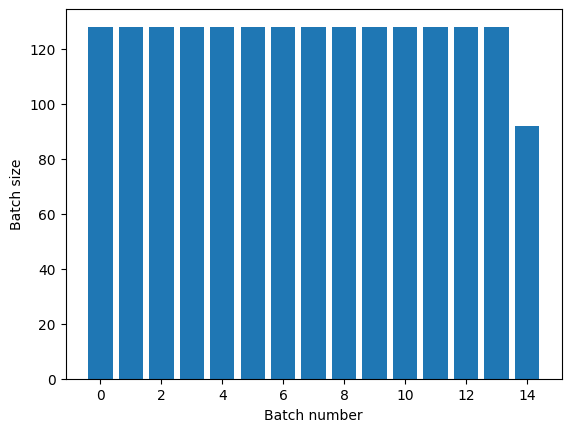

In [69]:
titanic_batches = titanic_lines.repeat(3).batch(128)
plot_batch_sizes(titanic_batches)

如果您需要明确的周期分隔，请将 `Dataset.batch` 置于重复前：

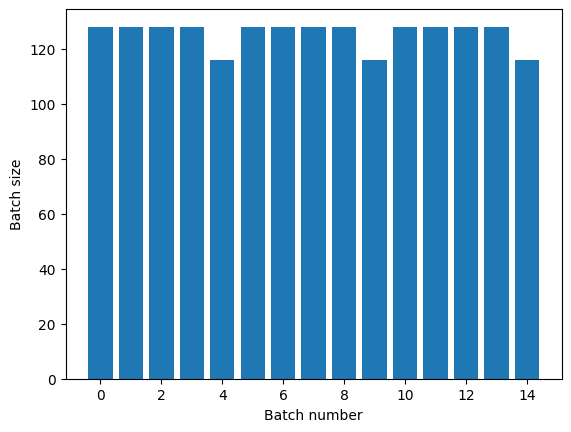

In [70]:
titanic_batches = titanic_lines.batch(128).repeat(3)

plot_batch_sizes(titanic_batches)

如果您想在每个周期结束时执行自定义计算（例如，收集统计信息），最简单的方式是在每个周期上重新启动数据集迭代：

In [71]:
epochs = 3
dataset = titanic_lines.batch(128)

for epoch in range(epochs):
  for batch in dataset:
    print(batch.shape)
  print("End of epoch: ", epoch)

(128,)
(128,)
(128,)
(128,)
(116,)
End of epoch:  0
(128,)
(128,)
(128,)
(128,)
(116,)
End of epoch:  1
(128,)
(128,)
(128,)
(128,)
(116,)
End of epoch:  2


### 随机重排输入数据

`Dataset.shuffle()` 转换会维持一个固定大小的缓冲区，并从该缓冲区均匀地随机选择下一个元素：

注：虽然较大的 buffer_size 可以更彻底地重排，但可能会占用大量的内存和时间来填充。如果这成为问题，请考虑跨文件使用 `Dataset.interleave`。

向数据集添加索引，便能看到效果：

In [72]:
lines = tf.data.TextLineDataset(titanic_file)
counter = tf.data.experimental.Counter()

dataset = tf.data.Dataset.zip((counter, lines))
dataset = dataset.shuffle(buffer_size=100)
dataset = dataset.batch(20)
dataset

Instructions for updating:
Use `tf.data.Dataset.counter(...)` instead.


<_BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

由于 `buffer_size` 是 100，而批次大小是 20，第一个批次不包含索引大于 120 的元素。

In [73]:
n,line_batch = next(iter(dataset))
print(n.numpy())

[  3  83  10  64   2  74  16  34  50 100   8  80  33  88  72  32   1  23
  42  78]


对于 `Dataset.batch`，与 `Dataset.repeat` 的相对顺序很重要。

在重排缓冲区为空之前，`Dataset.shuffle` 不会发出周期结束的信号。因此，置于重复之前的重排会先显示一个周期内的每个元素，然后移至下一个周期：

In [74]:
dataset = tf.data.Dataset.zip((counter, lines))
shuffled = dataset.shuffle(buffer_size=100).batch(10).repeat(2)

print("Here are the item ID's near the epoch boundary:\n")
for n, line_batch in shuffled.skip(60).take(5):
  print(n.numpy())

Here are the item ID's near the epoch boundary:

[415 625 578 600 194 497 615 426 471 598]
[414 606 498 363 465 604 515 619 539 450]
[520 445 529 617 614 469 504 607]
[75 12 66 94 60 57 42 20 44 19]
[23 34 98 95 56 21 47 28 71 97]


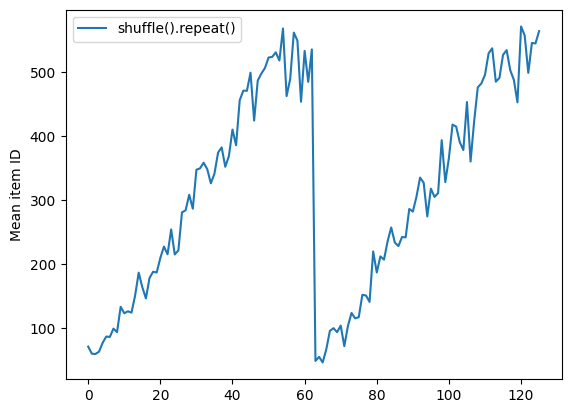

In [75]:
shuffle_repeat = [n.numpy().mean() for n, line_batch in shuffled]
plt.plot(shuffle_repeat, label="shuffle().repeat()")
plt.ylabel("Mean item ID")
plt.legend()

但在重排之前的重复会将周期边界混合在一起：

In [76]:
dataset = tf.data.Dataset.zip((counter, lines))
shuffled = dataset.repeat(2).shuffle(buffer_size=100).batch(10)

print("Here are the item ID's near the epoch boundary:\n")
for n, line_batch in shuffled.skip(55).take(15):
  print(n.numpy())

Here are the item ID's near the epoch boundary:

[627 369  20 426  24 438 462  10   1  23]
[601 522 615 607 484   6 294  15 546 581]
[ 38 562 539 603 593 623  39 465  33  44]
[503  16 620  14 609 560  21 577 473 536]
[529 525 573 519  36 594 532  29 611  51]
[507 608 231  35  62 624  50  32  66 591]
[ 76  47  73   0 505   3 542  88  87 464]
[ 71 610 477  26  43  96 568  57  54 482]
[554  75  83 574  48  93  72 100  70  55]
[  9  49  86  17  67  19  46 504 585 105]
[106 572 117  22  60  28 124 470  69  91]
[618  45 121  27 512 128  30  85  74 113]
[622  37 129  63 101  53 112 614  42 471]
[144 102 107 119  18  90 133 579 478  12]
[158 123 126 114 118  64   2 132 147 149]


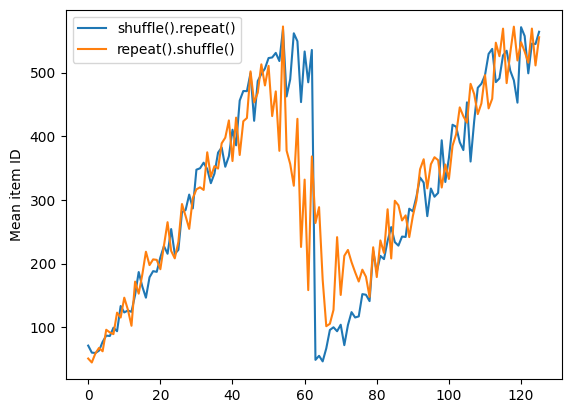

In [77]:
repeat_shuffle = [n.numpy().mean() for n, line_batch in shuffled]

plt.plot(shuffle_repeat, label="shuffle().repeat()")
plt.plot(repeat_shuffle, label="repeat().shuffle()")
plt.ylabel("Mean item ID")
plt.legend()

## 预处理数据

`Dataset.map(f)` 转换会通过对输入数据集的每个元素应用一个给定函数 `f` 来生成一个新的数据集。它基于 [`map()`](https://en.wikipedia.org/wiki/Map_(higher-order_function)) 函数，该函数通常应用于函数式编程语言中的列表（和其他结构）。函数 `f` 会获取在输入中表示单个元素的 `tf.Tensor` 对象，并返回在新数据集中表示单个元素的 `tf.Tensor` 对象。它的实现使用标准的 TensorFlow 运算来将一个元素转换为另一个元素。

本部分介绍了关于 `Dataset.map()` 使用方法的常见示例。


### 解码图像数据并调整大小

<!-- TODO(markdaoust): link to image augmentation when it exists -->

使用真实的图像数据训练神经网络时，常常需要将不同大小的图像转换为统一大小，以便将其批处理成某一固定大小。

重建花卉文件名数据集：

In [78]:
list_ds = tf.data.Dataset.list_files(str(flowers_root/'*/*'))

编写一个操作数据集元素的函数。

In [79]:
# Reads an image from a file, decodes it into a dense tensor, and resizes it
# to a fixed shape.
def parse_image(filename):
  parts = tf.strings.split(filename, os.sep)
  label = parts[-2]

  image = tf.io.read_file(filename)
  image = tf.io.decode_jpeg(image)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, [128, 128])
  return image, label

测试它的有效性。

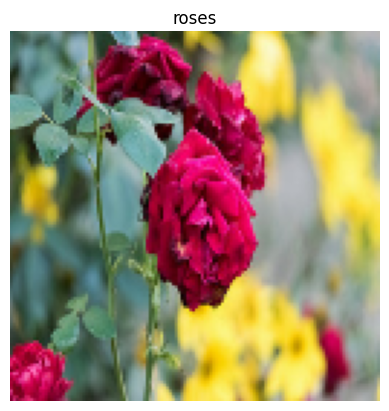

In [80]:
file_path = next(iter(list_ds))
image, label = parse_image(file_path)

def show(image, label):
  plt.figure()
  plt.imshow(image)
  plt.title(label.numpy().decode('utf-8'))
  plt.axis('off')

show(image, label)

将它映射到数据集。

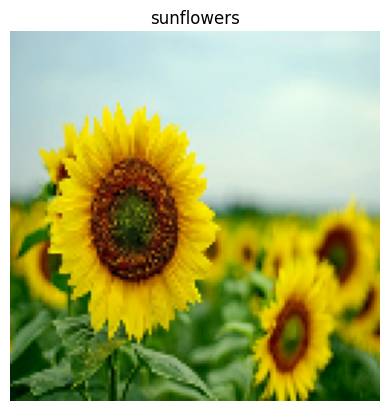

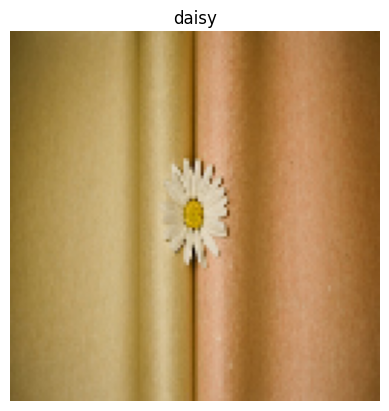

In [81]:
images_ds = list_ds.map(parse_image)

for image, label in images_ds.take(2):
  show(image, label)

### 应用任意 Python 逻辑

出于性能考虑，请尽可能使用 TensorFlow 运算预处理数据。不过，在解析输入数据时，调用外部 Python 库有时会很有帮助。您可以在 `Dataset.map` 转换中使用 `tf.py_function` 运算。

例如，如果您想应用一个随机旋转，而 `tf.image` 模块只有 `tf.image.rot90`，这对图像增强不是很有帮助。

注：`tensorflow_addons` 在 `tensorflow_addons.image.rotate` 中有一个与 TensorFlow 兼容的 `rotate`。

为了演示 `tf.py_function`，请尝试使用 `scipy.ndimage.rotate` 函数：

In [82]:
import scipy.ndimage as ndimage

def random_rotate_image(image):
  image = ndimage.rotate(image, np.random.uniform(-30, 30), reshape=False)
  return image

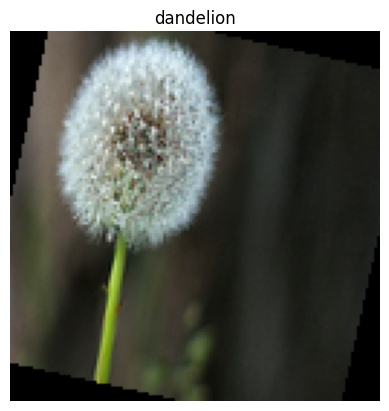

In [83]:
image, label = next(iter(images_ds))
image = random_rotate_image(image)
show(image, label)

要将此函数用于 `Dataset.map`，需留意与 `Dataset.from_generator` 相同的注意事项，在应用该函数时需要描述返回的形状和类型：

In [84]:
def tf_random_rotate_image(image, label):
  im_shape = image.shape
  [image,] = tf.py_function(random_rotate_image, [image], [tf.float32])
  image.set_shape(im_shape)
  return image, label

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.13773246..1.0865866].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.14311765..0.9531854].


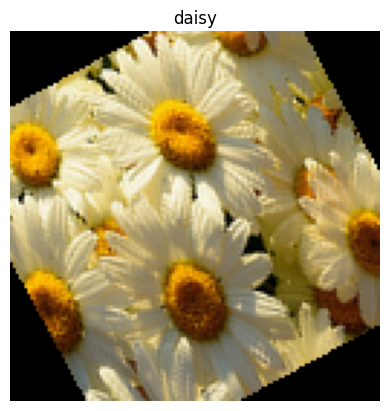

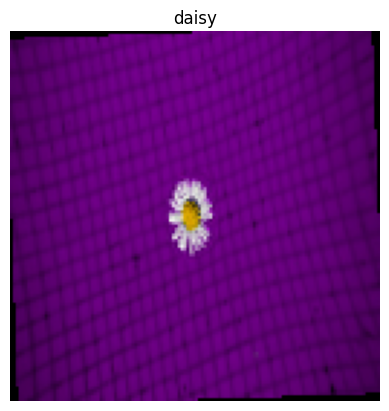

In [85]:
rot_ds = images_ds.map(tf_random_rotate_image)

for image, label in rot_ds.take(2):
  show(image, label)

### 解析 `tf.Example` 协议缓冲区消息

许多输入流水线从 TFRecord 格式文件中提取 `tf.train.Example` 协议缓冲区消息。每个 `tf.train.Example` 记录包含一个或多个“特征”，而输入流水线通常会将这些特征转换为张量。

In [86]:
fsns_test_file = tf.keras.utils.get_file("fsns.tfrec", "https://storage.googleapis.com/download.tensorflow.org/data/fsns-20160927/testdata/fsns-00000-of-00001")
dataset = tf.data.TFRecordDataset(filenames = [fsns_test_file])
dataset

<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

您可以在 `tf.data.Dataset` 外部使用 `tf.train.Example` 协议来理解数据：

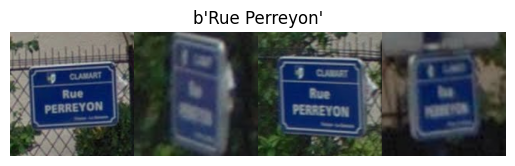

In [87]:
raw_example = next(iter(dataset))
parsed = tf.train.Example.FromString(raw_example.numpy())

feature = parsed.features.feature
raw_img = feature['image/encoded'].bytes_list.value[0]
img = tf.image.decode_png(raw_img)
plt.imshow(img)
plt.axis('off')
_ = plt.title(feature["image/text"].bytes_list.value[0])

In [88]:
raw_example = next(iter(dataset))

In [89]:
def tf_parse(eg):
  example = tf.io.parse_example(
      eg[tf.newaxis], {
          'image/encoded': tf.io.FixedLenFeature(shape=(), dtype=tf.string),
          'image/text': tf.io.FixedLenFeature(shape=(), dtype=tf.string)
      })
  return example['image/encoded'][0], example['image/text'][0]

In [90]:
img, txt = tf_parse(raw_example)
print(txt.numpy())
print(repr(img.numpy()[:20]), "...")

b'Rue Perreyon'
b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02X' ...


In [91]:
decoded = dataset.map(tf_parse)
decoded

<_MapDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>

In [92]:
image_batch, text_batch = next(iter(decoded.batch(10)))
image_batch.shape

TensorShape([10])

<a id="time_series_windowing"></a>

### 时间序列窗口化

有关端到端的时间序列示例，请参阅：[时间序列预测](../../tutorials/structured_data/time_series.ipynb)。

时间序列数据通常以保持完整时间轴的方式进行组织。

用一个简单的 `Dataset.range` 来演示：

In [93]:
range_ds = tf.data.Dataset.range(100000)

通常，基于此类数据的模型需要一个连续的时间片。

最简单的方式是批处理这些数据：

#### 使用 `batch`

In [94]:
batches = range_ds.batch(10, drop_remainder=True)

for batch in batches.take(5):
  print(batch.numpy())

[0 1 2 3 4 5 6 7 8 9]
[10 11 12 13 14 15 16 17 18 19]
[20 21 22 23 24 25 26 27 28 29]
[30 31 32 33 34 35 36 37 38 39]
[40 41 42 43 44 45 46 47 48 49]


或者，要对未来进行一步密集预测，您可以将特征和标签相对彼此移动一步：

In [95]:
def dense_1_step(batch):
  # Shift features and labels one step relative to each other.
  return batch[:-1], batch[1:]

predict_dense_1_step = batches.map(dense_1_step)

for features, label in predict_dense_1_step.take(3):
  print(features.numpy(), " => ", label.numpy())

[0 1 2 3 4 5 6 7 8]  =>  [1 2 3 4 5 6 7 8 9]
[10 11 12 13 14 15 16 17 18]  =>  [11 12 13 14 15 16 17 18 19]
[20 21 22 23 24 25 26 27 28]  =>  [21 22 23 24 25 26 27 28 29]


2024-10-25 20:21:40.662370: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


要预测整个窗口而非一个固定偏移量，您可以将批次分成两部分：

In [96]:
batches = range_ds.batch(15, drop_remainder=True)

def label_next_5_steps(batch):
  return (batch[:-5],   # Inputs: All except the last 5 steps
          batch[-5:])   # Labels: The last 5 steps

predict_5_steps = batches.map(label_next_5_steps)

for features, label in predict_5_steps.take(3):
  print(features.numpy(), " => ", label.numpy())

[0 1 2 3 4 5 6 7 8 9]  =>  [10 11 12 13 14]
[15 16 17 18 19 20 21 22 23 24]  =>  [25 26 27 28 29]
[30 31 32 33 34 35 36 37 38 39]  =>  [40 41 42 43 44]


要允许一个批次的特征和另一批次的标签部分重叠，请使用 `Dataset.zip`：

In [97]:
feature_length = 10
label_length = 3

features = range_ds.batch(feature_length, drop_remainder=True)
labels = range_ds.batch(feature_length).skip(1).map(lambda labels: labels[:label_length])

predicted_steps = tf.data.Dataset.zip((features, labels))

for features, label in predicted_steps.take(5):
  print(features.numpy(), " => ", label.numpy())

[0 1 2 3 4 5 6 7 8 9]  =>  [10 11 12]
[10 11 12 13 14 15 16 17 18 19]  =>  [20 21 22]
[20 21 22 23 24 25 26 27 28 29]  =>  [30 31 32]
[30 31 32 33 34 35 36 37 38 39]  =>  [40 41 42]
[40 41 42 43 44 45 46 47 48 49]  =>  [50 51 52]


#### 使用 `window`

尽管使用 `Dataset.batch` 奏效，某些情况可能需要更精细的控制。`Dataset.window` 方法可以为您提供完全控制，但需要注意：它返回的是由 `Datasets` 组成的 `Dataset`。请参阅[数据集结构](#dataset_structure)部分以了解详情。

In [98]:
window_size = 5

windows = range_ds.window(window_size, shift=1)
for sub_ds in windows.take(5):
  print(sub_ds)

<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>


`Dataset.flat_map` 方法可以获取由数据集组成的数据集，并将其合并为一个数据集：

In [99]:
 for x in windows.flat_map(lambda x: x).take(30):
   print(x.numpy(), end=' ')

0 1 2 3 4 1 2 3 4 5 2 3 4 5 6 3 4 5 6 7 4 5 6 7 8 5 6 7 8 9 

在几乎所有情况下，您都需要先 `Dataset.batch` 数据集：

In [100]:
def sub_to_batch(sub):
  return sub.batch(window_size, drop_remainder=True)

for example in windows.flat_map(sub_to_batch).take(5):
  print(example.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]


现在，您可以看到 `shift` 参数控制着每个窗口的移动量。

将上述内容整合起来，您就可以编写出以下函数：

In [101]:
def make_window_dataset(ds, window_size=5, shift=1, stride=1):
  windows = ds.window(window_size, shift=shift, stride=stride)

  def sub_to_batch(sub):
    return sub.batch(window_size, drop_remainder=True)

  windows = windows.flat_map(sub_to_batch)
  return windows


In [102]:
ds = make_window_dataset(range_ds, window_size=10, shift = 5, stride=3)

for example in ds.take(10):
  print(example.numpy())

[ 0  3  6  9 12 15 18 21 24 27]
[ 5  8 11 14 17 20 23 26 29 32]
[10 13 16 19 22 25 28 31 34 37]
[15 18 21 24 27 30 33 36 39 42]
[20 23 26 29 32 35 38 41 44 47]
[25 28 31 34 37 40 43 46 49 52]
[30 33 36 39 42 45 48 51 54 57]
[35 38 41 44 47 50 53 56 59 62]
[40 43 46 49 52 55 58 61 64 67]
[45 48 51 54 57 60 63 66 69 72]


然后，可以像之前一样轻松提取标签：

In [103]:
dense_labels_ds = ds.map(dense_1_step)

for inputs,labels in dense_labels_ds.take(3):
  print(inputs.numpy(), "=>", labels.numpy())

[ 0  3  6  9 12 15 18 21 24] => [ 3  6  9 12 15 18 21 24 27]
[ 5  8 11 14 17 20 23 26 29] => [ 8 11 14 17 20 23 26 29 32]
[10 13 16 19 22 25 28 31 34] => [13 16 19 22 25 28 31 34 37]


### 重采样

在处理类非常不平衡的数据集时，您可能需要对数据集重新采样。`tf.data` 为此提供了两种方法。信用卡欺诈数据集就是此类问题一个很好的例子。

注：请转到[不平衡数据分类](../tutorials/structured_data/imbalanced_data.ipynb)了解完整教程。


In [104]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/download.tensorflow.org/data/creditcard.zip',
    fname='creditcard.zip',
    extract=True)

csv_path = zip_path.replace('.zip', '.csv')

69155632/69155632 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


In [105]:
creditcard_ds = tf.data.experimental.make_csv_dataset(
    csv_path, batch_size=1024, label_name="Class",
    # Set the column types: 30 floats and an int.
    column_defaults=[float()]*30+[int()])

现在，检查类的分布，它是高度倾斜的：

In [106]:
def count(counts, batch):
  features, labels = batch
  class_1 = labels == 1
  class_1 = tf.cast(class_1, tf.int32)

  class_0 = labels == 0
  class_0 = tf.cast(class_0, tf.int32)

  counts['class_0'] += tf.reduce_sum(class_0)
  counts['class_1'] += tf.reduce_sum(class_1)

  return counts

In [107]:
counts = creditcard_ds.take(10).reduce(
    initial_state={'class_0': 0, 'class_1': 0},
    reduce_func = count)

counts = np.array([counts['class_0'].numpy(),
                   counts['class_1'].numpy()]).astype(np.float32)

fractions = counts/counts.sum()
print(fractions)

[0.996 0.004]


使用不平衡的数据集进行训练的一种常用方式是使其平衡。`tf.data` 包括一些能够让此工作流变得可行的方法：

#### 数据集采样

对数据集重新采样的一种方式是使用 `sample_from_datasets`。当每个类都有单独的 `tf.data.Dataset` 时，这种方式更加适用。

下面用过滤器从信用卡欺诈数据中生成一个重采样数据集：

In [108]:
negative_ds = (
  creditcard_ds
    .unbatch()
    .filter(lambda features, label: label==0)
    .repeat())
positive_ds = (
  creditcard_ds
    .unbatch()
    .filter(lambda features, label: label==1)
    .repeat())

In [109]:
for features, label in positive_ds.batch(10).take(1):
  print(label.numpy())

[1 1 1 1 1 1 1 1 1 1]


要使用 `tf.data.Dataset.sample_from_datasets` 传递数据集以及每个数据集的权重，请运行以下代码：

In [110]:
balanced_ds = tf.data.Dataset.sample_from_datasets(
    [negative_ds, positive_ds], [0.5, 0.5]).batch(10)

现在，数据集为每个类生成样本的概率是 50/50：

In [111]:
for features, labels in balanced_ds.take(10):
  print(labels.numpy())

[0 1 1 1 0 0 0 0 0 1]
[0 0 0 1 1 0 1 1 1 0]
[1 0 1 0 1 0 1 1 1 0]
[1 1 0 0 0 0 1 0 0 0]
[0 1 1 1 1 0 0 1 1 1]
[1 1 0 1 0 1 1 0 1 1]
[0 1 1 0 1 1 1 0 1 1]
[0 1 1 0 1 1 0 0 0 1]
[1 0 1 0 1 1 1 1 1 0]
[1 1 1 1 1 1 0 0 0 1]


#### 拒绝重采样

上述 `Dataset.sample_from_datasets` 方式的一个问题是每个类需要一个单独的 `tf.data.Dataset`。您可以使用 `Dataset.filter` 创建这两个数据集，但这会导致所有数据被加载两次。

可以将 `tf.data.Dataset.rejection_resample` 方法应用于数据集以使其重新平衡，而且只需加载一次数据。元素将被删除或重复，以实现平衡。

`rejection_resample` 需要一个 `class_func` 参数。这个 `class_func` 参数会被应用至每个数据集元素，并且会被用来确定某个样本属于哪一类，以实现平衡的目的。

这里的目标是平衡标签分布，而 `creditcard_ds` 的元素已经形成 `(features, label)` 对。因此，`class_func` 只需返回这些标签：

In [112]:
def class_func(features, label):
  return label

重采样方法会处理单个样本，因此您必须在应用该方法前 `unbatch` 数据集。

该方法需要一个目标分布，以及一个可选的初始分布估计作为输入：

In [113]:
resample_ds = (
    creditcard_ds
    .unbatch()
    .rejection_resample(class_func, target_dist=[0.5,0.5],
                        initial_dist=fractions)
    .batch(10))

Instructions for updating:
Use tf.print instead of tf.Print. Note that tf.print returns a no-output operator that directly prints the output. Outside of defuns or eager mode, this operator will not be executed unless it is directly specified in session.run or used as a control dependency for other operators. This is only a concern in graph mode. Below is an example of how to ensure tf.print executes in graph mode:



`rejection_resample` 方法会返回 `(class, example)` 对，其中的 `class` 为 `class_func` 的输出。在此例中，`example` 已经形成 `(feature, label)` 对，因此请使用 `map` 删除多余的标签副本：

In [114]:
balanced_ds = resample_ds.map(lambda extra_label, features_and_label: features_and_label)

现在，数据集为每个类生成样本的概率是 50/50：

In [115]:
for features, labels in balanced_ds.take(10):
  print(labels.numpy())

Proportion of examples rejected by sampler is high: [0.995996118][0.995996118 0.00400390616][0 1]
Proportion of examples rejected by sampler is high: [0.995996118][0.995996118 0.00400390616][0 1]
Proportion of examples rejected by sampler is high: [0.995996118][0.995996118 0.00400390616][0 1]
Proportion of examples rejected by sampler is high: [0.995996118][0.995996118 0.00400390616][0 1]
Proportion of examples rejected by sampler is high: [0.995996118][0.995996118 0.00400390616][0 1]
Proportion of examples rejected by sampler is high: [0.995996118][0.995996118 0.00400390616][0 1]
Proportion of examples rejected by sampler is high: [0.995996118][0.995996118 0.00400390616][0 1]
Proportion of examples rejected by sampler is high: [0.995996118][0.995996118 0.00400390616][0 1]
Proportion of examples rejected by sampler is high: [0.995996118][0.995996118 0.00400390616][0 1]
Proportion of examples rejected by sampler is high: [0.995996118][0.995996118 0.00400390616][0 1]


[0 0 1 0 1 1 1 1 0 0]
[0 0 1 0 0 1 1 1 1 1]
[1 1 1 1 1 0 0 0 0 0]
[0 0 1 1 1 0 1 1 0 0]
[0 0 0 0 0 1 0 1 0 0]
[0 1 1 1 0 1 1 1 1 1]
[1 0 0 1 0 1 1 1 0 1]
[1 0 1 0 0 0 0 1 0 0]
[1 1 0 0 0 1 0 1 0 0]
[0 1 1 0 1 1 0 1 1 1]


## 迭代器检查点操作

TensorFlow 支持[获取检查点 ](./checkpoint.ipynb)，这样当训练过程重启时，可以还原至最新的检查点，从而恢复大部分进度。除了可以对模型变量进行检查点操作外，您还可以为数据集迭代器的进度设置检查点。如果您有一个很大的数据集，并且不想在每次重启后都从头开始，此功能会非常有用。但是请注意，迭代器检查点可能会很大，因为像 `Dataset.shuffle` 和 `Dataset.prefetch` 之类的转换需要在迭代器内缓冲元素。

要在检查点中包含迭代器，请将迭代器传递至 `tf.train.Checkpoint` 构造函数。

In [116]:
range_ds = tf.data.Dataset.range(20)

iterator = iter(range_ds)
ckpt = tf.train.Checkpoint(step=tf.Variable(0), iterator=iterator)
manager = tf.train.CheckpointManager(ckpt, '/tmp/my_ckpt', max_to_keep=3)

print([next(iterator).numpy() for _ in range(5)])

save_path = manager.save()

print([next(iterator).numpy() for _ in range(5)])

ckpt.restore(manager.latest_checkpoint)

print([next(iterator).numpy() for _ in range(5)])

[0, 1, 2, 3, 4]
[5, 6, 7, 8, 9]
[5, 6, 7, 8, 9]


注：无法为依赖于外部状态的迭代器（例如 `tf.py_function`）设置检查点。尝试这样做将引发外部状态异常。

## 结合使用 tf.data 与 tf.keras

`tf.keras` API 在创建和执行机器学习模型的许多方面进行了简化。它的 `Model.fit`、`Model.evaluate` 和 `Model.predict` API 支持将数据集作为输入。下面是一个快速的数据集和模型设置：

In [117]:
train, test = tf.keras.datasets.fashion_mnist.load_data()

images, labels = train
images = images/255.0
labels = labels.astype(np.int32)

In [118]:
fmnist_train_ds = tf.data.Dataset.from_tensor_slices((images, labels))
fmnist_train_ds = fmnist_train_ds.shuffle(5000).batch(32)

model = tf.keras.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(10)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

只需向 `Model.fit` 和 `Model.evaluate` 传递一个由 `(feature, label)` 对组成的数据集：

In [119]:
model.fit(fmnist_train_ds, epochs=2)

Epoch 1/2


I0000 00:00:1729858927.997914 4142651 service.cc:146] XLA service 0x7fdd000064a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729858927.997951 4142651 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
I0000 00:00:1729858927.997959 4142651 service.cc:154]   StreamExecutor device (1): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2024-10-25 20:22:08.018257: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-25 20:22:08.090703: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


  76/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3665 - loss: 1.8373  

I0000 00:00:1729858928.930787 4142651 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7305 - loss: 0.7949
Epoch 2/2
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8398 - loss: 0.4701


如果您要传递一个无限大的数据集（比如通过调用 `Dataset.repeat`），您只需要同时传递 `steps_per_epoch` 参数：

In [120]:
model.fit(fmnist_train_ds.repeat(), epochs=2, steps_per_epoch=20)

Epoch 1/2
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8635 - loss: 0.5103  
Epoch 2/2
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8486 - loss: 0.4637


对于评估，可以传递评估步数：

In [121]:
loss, accuracy = model.evaluate(fmnist_train_ds)
print("Loss :", loss)
print("Accuracy :", accuracy)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8397 - loss: 0.4569
Loss : 0.4572630822658539
Accuracy : 0.840149998664856


对于长数据集，可以设置要评估的步数：

In [122]:
loss, accuracy = model.evaluate(fmnist_train_ds.repeat(), steps=10)
print("Loss :", loss)
print("Accuracy :", accuracy)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8217 - loss: 0.4931  
Loss : 0.47733569145202637
Accuracy : 0.809374988079071


调用 `Model.predict` 时不需要标签。

In [ ]:
predict_ds = tf.data.Dataset.from_tensor_slices(images).batch(32)
result = model.predict(predict_ds, steps = 10)
print(result.shape)

但是，如果您传递了包含标签的数据集，则标签会被忽略：

In [ ]:
result = model.predict(fmnist_train_ds, steps = 10)
print(result.shape)